In [41]:
%%bash

pip install pandas numpy gql networkx matplotlib pygraphviz

  Running setup.py install for pygraphviz: started
    Running setup.py install for pygraphviz: finished with status 'done'


You should consider upgrading via the 'pip install --upgrade pip' command.


In [271]:
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport
import networkx as nx
from matplotlib import pyplot as plt
import itertools
import textwrap

%matplotlib inline

In [4]:
# Use a local server
# GRAPHQL_ENDPOINT = "http://localhost:8080/v1/graphql"

# Use the public endpoint
# !! Please be gentle with your queries! 
# !! This is running on a small postgres server that I'm paying for, so please don't overload it with automated scripts. 
# !! As long as you're running queries by hand through notebooks everything should be fine.
GRAPHQL_ENDPOINT = "http://papergraph.dennybritz.com/v1/graphql"

In [5]:
# create a graphql client

transport = RequestsHTTPTransport(
    url=GRAPHQL_ENDPOINT,
    use_json=True,
    headers={"Content-type": "application/json"},
    verify=False)

client = Client(
    retries=3,
    transport=transport,
    fetch_schema_from_transport=True)

# Query the database

Let's get some data. The following code queries the GraphQL endpoint and gets the 2-level citation graph for a specific paper. It retrieves all papers at most 2 hops away. Assuming each paper on average cites 30 other papers, the result would be 1 + 30 * 30 = ~900 records. Note that the database currently only contains papers labeled as "Computer Science", so cited papers from other fields will not show up.

In [6]:
# Paper title is matched via sql LIKE, so use can use % operators for text matching
PAPER_TITLE = "%Mastering Atari, Go, Chess and Shogi by Planning%"

In [7]:
query = gql("""
fragment paper_fields on papers {
  id
  title
  year
  doi_url
  s2_url
  num_citations
}

query papers($title: String!) {
  papers(limit: 1, where: {title: {_like: $title}}, offset: 0) {
    ...paper_fields
    cites(args: {limit_: 100}) {
      ...paper_fields
      cites(args: {limit_: 100}) {
        ...paper_fields
      }
    }
  }
}
""")

In [8]:
papers = client.execute(query, variable_values={"title": PAPER_TITLE})
root = papers["papers"][0]

In [9]:
def process_recursively(paper, fn):
    """Helper function to process the recursive graph data structure. It runs a function for each element in the graph"""
    fn(paper)
    if not "cites" in paper:
        return
    for cited_paper in paper["cites"]:
        process_recursively(cited_paper, fn)

# Create Graph

Next, let's create a networkx graph object from our data.

In [130]:
g = nx.DiGraph()

In [131]:
def add_nodes_to_graph(paper):
    paper_id = paper["id"]
    if paper_id not in g:
        fields = { k : paper[k] for k in paper if k != "cites" }
        g.add_node(paper_id, **fields)
        
def add_edges_to_graph(paper):
    paper_id = paper["id"]
    if not "cites" in paper:
        return
    for cited_paper in paper["cites"]:
        g.add_edge(paper_id, cited_paper["id"])

In [132]:
process_recursively(root, add_nodes_to_graph)
process_recursively(root, add_edges_to_graph)

In [151]:
print("Nodes with the highest in-degree:\n")

in_degree_list = sorted(g.in_degree, key=lambda x: x[1], reverse=True)
for (node_id, in_degree) in itertools.islice(in_degree_list, 25):
    title = g.nodes[node_id]["title"]
    print(f"[{in_degree}] {title}")

Nodes with the highest in-degree:

[18] Human-level control through deep reinforcement learning
[15] The Arcade Learning Environment: An Evaluation Platform for General Agents (Extended Abstract)
[14] Asynchronous Methods for Deep Reinforcement Learning
[14] Reinforcement Learning: An Introduction
[9] Action-Conditional Video Prediction using Deep Networks in Atari Games
[8] Rainbow: Combining Improvements in Deep Reinforcement Learning
[8] Deep Reinforcement Learning with Double Q-Learning
[8] Learning to Predict by the Methods of Temporal Differences
[8] Prioritized Experience Replay
[8] Mastering the game of Go with deep neural networks and tree search
[8] PILCO: A Model-Based and Data-Efficient Approach to Policy Search
[8] Bandit Based Monte-Carlo Planning
[7] Playing Atari with Deep Reinforcement Learning
[7] Dueling Network Architectures for Deep Reinforcement Learning
[7] Reinforcement Learning with Unsupervised Auxiliary Tasks
[7] The Predictron: End-To-End Learning and Planni

In [125]:
# Export data to json to load with d3js
from networkx.readwrite import json_graph
import json
# json_graph.node_link_data(g) 

## Visualization

Let's use `networkx`'s built-in visualization capabilities to create a graph.

In [161]:
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph

In [234]:
# Compute the positions of all all nodes
pos = graphviz_layout(g, prog="twopi", root=root["id"])

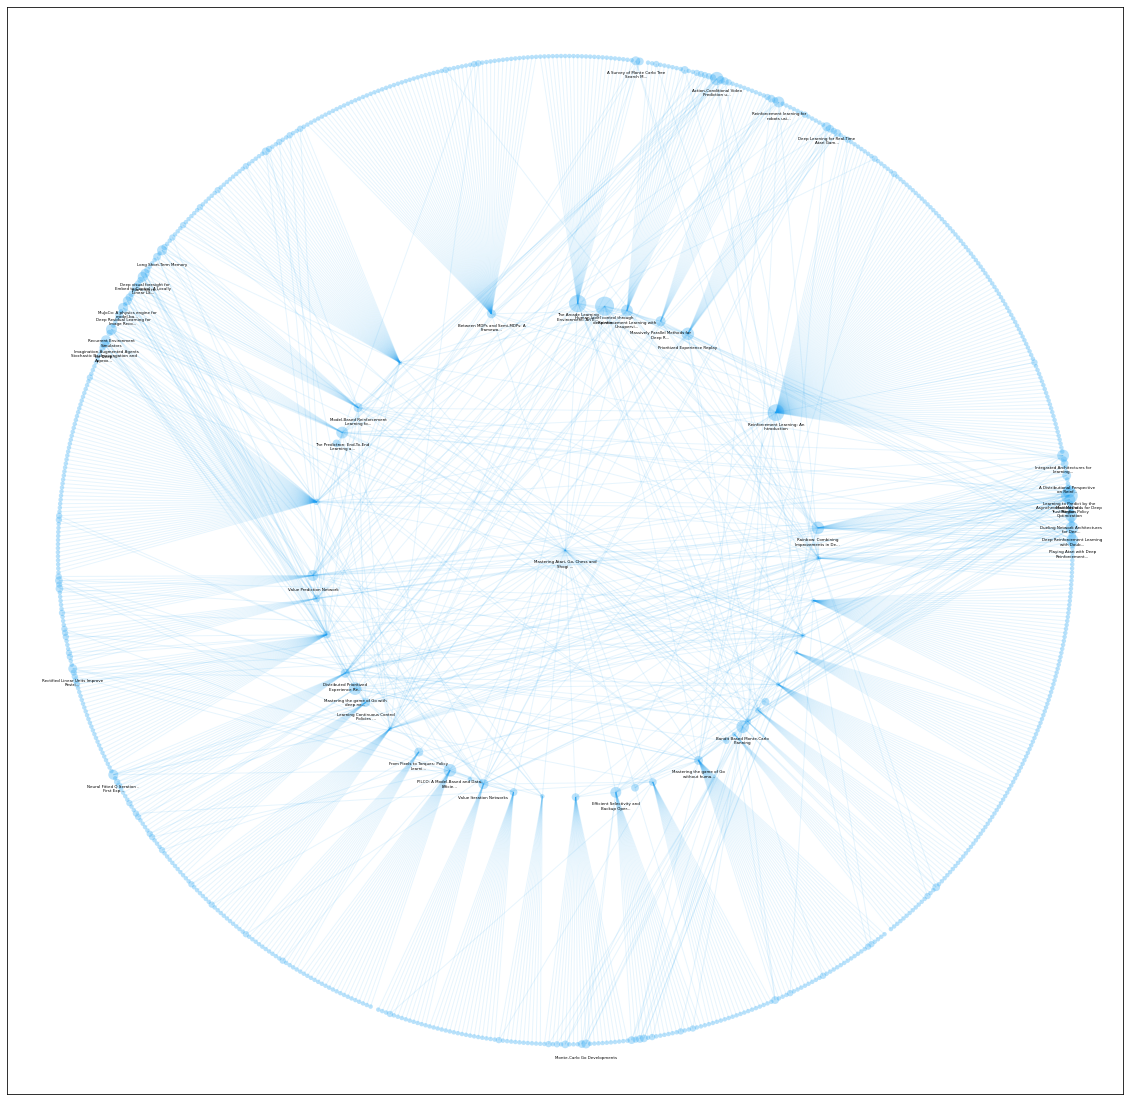

In [273]:
NODE_COLOR = "#1DA1F2"
EDGE_COLOR = NODE_COLOR

plt.figure(figsize=(20, 20))

# draw nodes
# ==================================================
# nodes are scaled based on their in-degree in this subgraph
node_size = [g.in_degree(n) * 20 for n in g.nodes()]
nx.draw_networkx_nodes(g, pos, node_color=NODE_COLOR, node_size=node_size, alpha=0.3, linewidths=0)

# draw edges
# ==================================================
nx.draw_networkx_edges(g, pos, edge_color="#1DA1F2", node_size=node_size, arrows=False, alpha=0.1)

# draw labels
# ==================================================

# We only display labels for nodes with a high in-degree
# and we truncate the title to 40 chars
def get_node_label(node):
    if g.in_degree(node) > 3 or node == root["id"]:
        title = g.nodes[node]["title"]
        title = (title[:37] + '...') if len(title) > 40 else title
        title = "\n".join(textwrap.wrap(title, 30, break_long_words=False))
        return title
    return ""
labels = { n: get_node_label(n) for n  in g.nodes() }

# labels are displayed a little bit below the node
label_positions = { n: (pos[n][0], pos[n][1] - 4)  for n in pos}

nx.draw_networkx_labels(g, label_positions, labels, font_size=4)

# draw it!
plt.savefig("graph.pdf")
plt.savefig("graph.svg")